In [1]:
import sys, os
from os.path import join, dirname, abspath
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
import numpy as np
import networkx as nx
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
from numpy.linalg import matrix_power, eig
from string import ascii_uppercase

from car import Car
from tiles import Road, Exit
from world import World
from directions import *

plt.rcParams.update({
    "text.usetex": False,
    "ytick.minor.visible":True,
    "xtick.minor.visible":True,
    'xtick.direction': "in",
    'ytick.direction': "in"
})
outdir = "out"
os.makedirs(outdir,exist_ok=True)
def out(fname): return join(outdir,fname)
def savefig(plot_name): 
    plt.savefig(out(plot_name),bbox_inches="tight",dpi=250)

def arr_to_latex(M):
    return '$$\n' + r'\begin{bmatrix}' + '\n' + (r'\\' + '\n').join('&'.join(str(x) for x in row) for row in M) + '\n' + r'\end{bmatrix}' + '\n' +'$$'

def vec_to_latex(x,round=3):
    return '$$\n' + r'\begin{bmatrix}' + '\n' + (r' \\ ').join(str(np.round(v,round)) for v in x) + '\n' + r'\end{bmatrix}' + '\n' +'$$'

In [2]:
GRID_WIDTH = 20
GRID_HEIGHT = 20
rng = np.random.default_rng()

In [3]:
road_tiles = []
for i in range(0,GRID_WIDTH):
    for j in range(0,GRID_HEIGHT):
        # if not ((j == 2 or j == 3) and i == 2):
        if rng.random() >= 0.1:
            direction = rng.random() * rng.choice(directions)
            for _ in range(10):
                direction += rng.random() * rng.choice(directions)
            direction /= np.sum(direction)
            # print(direction)
            # print(np.sum(direction))
            road_tiles.append(Road(i,j,direction))
len(road_tiles)

360

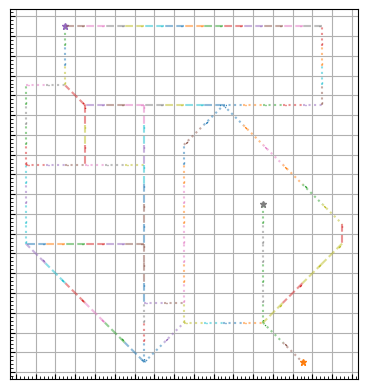

In [4]:
s = []
s.append(Road(6,0,(NW+N+NE)/3))
s.append(Exit(14,0))
s.append(Road(5,1,NW))
s.append(Road(6,1,N))
s.append(Road(7,1,NE))
s.append(Road(13,1,SE))
s.append(Road(4,2,NW))
s.append(Road(6,2,N))
s.append(Road(8,2,(N+E)/2))
s.append(Road(9,2,E))
s.append(Road(10,2,E))
s.append(Road(11,2,E))
s.append(Road(12,2,(N+SE)/2))
s.append(Road(3,3,NW))
s.append(Road(6,3,E))
s.append(Road(7,3,E))
s.append(Road(8,3,N))
s.append(Road(12,3,N))
s.append(Road(13,3,SW))
s.append(Road(2,4,NW))
s.append(Road(6,4,S))
s.append(Road(8,4,N))
s.append(Road(12,4,N))
s.append(Road(14,4,SW))
s.append(Road(1,5,NW))
s.append(Road(6,5,S))
s.append(Road(8,5,N))
s.append(Road(12,5,N))
s.append(Road(15,5,SW))
s.append(Road(0,6,N))
s.append(Road(1,6,W))
s.append(Road(2,6,W))
s.append(Road(3,6,W))
s.append(Road(4,6,W))
s.append(Road(5,6,W))
s.append(Road(6,6,(W+S)/2))
s.append(Road(8,6,N))
s.append(Road(12,6,N))
s.append(Road(16,6,SW))
s.append(Road(0,7,N))
s.append(Road(6,7,S))
s.append(Road(8,7,N))
s.append(Road(12,7,N))
s.append(Road(16,7,S))
s.append(Road(0,8,N))
s.append(Road(6,8,S))
s.append(Road(8,8,N))
s.append(Exit(12,8))
s.append(Road(15,8,SE))
s.append(Road(0,9,N))
s.append(Road(6,9,S))
s.append(Road(8,9,N))
s.append(Road(14,9,SE))
s.append(Road(0,10,(N+E)/2))
s.append(Road(1,10,E))
s.append(Road(2,10,E))
s.append(Road(3,10,E))
s.append(Road(4,10,E))
s.append(Road(5,10,E))
s.append(Road(6,10,S))
s.append(Road(8,10,N))
s.append(Road(13,10,SE))
s.append(Road(0,11,N))
s.append(Road(3,11,S))
s.append(Road(6,11,S))
s.append(Road(8,11,NE))
s.append(Road(12,11,SE))
s.append(Road(0,12,N))
s.append(Road(3,12,S))
s.append(Road(6,12,S))
s.append(Road(9,12,NE))
s.append(Road(11,12,SE))
s.append(Road(0,13,N))
s.append(Road(3,13,(S+NW)/2))
s.append(Road(4,13,W))
s.append(Road(5,13,W))
s.append(Road(6,13,(S+W)/2))
s.append(Road(7,13,W))
s.append(Road(8,13,W))
s.append(Road(9,13,W))
s.append(Road(10,13,(W+E+SE)/3))
s.append(Road(11,13,E))
s.append(Road(12,13,E))
s.append(Road(13,13,E))
s.append(Road(14,13,E))
s.append(Road(15,13,N))
s.append(Road(0,14,E))
s.append(Road(1,14,E))
s.append(Road(2,14,N))
s.append(Road(15,14,N))
s.append(Road(2,15,N))
s.append(Road(15,15,N))
s.append(Road(2,16,N))
s.append(Road(15,16,N))
s.append(Exit(2,17))
s.append(Road(3,17,W))
s.append(Road(4,17,W))
s.append(Road(5,17,W))
s.append(Road(6,17,W))
s.append(Road(7,17,W))
s.append(Road(8,17,W))
s.append(Road(9,17,W))
s.append(Road(10,17,W))
s.append(Road(11,17,W))
s.append(Road(12,17,W))
s.append(Road(13,17,W))
s.append(Road(14,17,W))
s.append(Road(15,17,W))


w = World(tiles=s, cars=[])
w.draw(markersize=5)


In [5]:
num_steps = 100

In [28]:
m = w.markov
c = np.zeros(m.shape[0])
c[0] = 1
car_locs = [c]
for _ in range(num_steps-1):
    car_locs.append(m.T@car_locs[-1])
car_locs = np.array(car_locs)

In [29]:
m.T@(m.T@c)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [30]:
m[1,:]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

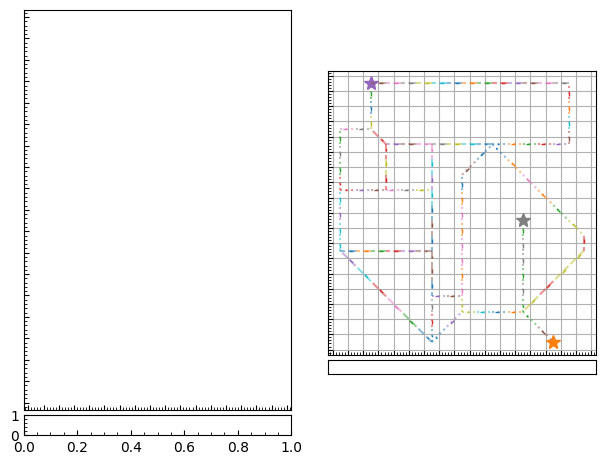

In [31]:
fig, axes = plt.subplots(1,2,sharex=True,sharey=True)
fig.tight_layout()
div = make_axes_locatable(axes[0])
cax = div.append_axes("bottom", size="5%", pad=0.05)
d2 = make_axes_locatable(axes[1])
cax2 = d2.append_axes("bottom", size="5%", pad=0.05)
cax2.get_xaxis().set_visible(False)
cax2.get_yaxis().set_visible(False)

w.draw(ax=axes[1],connections=True,markersize=10)

def update(frame):
    ax = axes[0]
    ax.cla()
    cax.cla()
    heatmap = np.zeros((GRID_HEIGHT,GRID_WIDTH))
    for i,t in enumerate(w._tiles):
        heatmap[t.y,t.x] = car_locs[frame][i]
    im = ax.imshow(heatmap,cmap="inferno",origin="lower")
    cb1 = fig.colorbar(im,cax=cax,label="P(Car in Tile)",location="bottom")
    # cb1 = fig.colorbar(im,ax=ax,label="P(Car in Tile)",location="bottom")
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.bar(np.arange(len(car_locs[frame])),car_locs[frame])
    # ax.set_ylim(0,1)
    # ax.set_xlabel("Road Tile")
    # ax.set_ylabel("P(Road Tile)")
    fig.suptitle("Markov Chain Model for Car in Network")
    ax.set_title(f"t = {frame}")

    
ani = animation.FuncAnimation(fig,update,frames=len(car_locs),interval=100)
ani.save(filename=out("random_connections.gif"), writer="pillow",dpi=150)